In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import squidpy as sq
import anndata as ad
import scipy.stats as stats
import tacco as tc
import os

# Sample XETG00102__0015463_B015_A2__20240510__194155

In [3]:
# read in matrix file
adata = sc.read_10x_h5(
    filename="/Users/stephreinert/Desktop/xenium/xenium_intestine/output_XETG00102__0015463_B015_A2__20240510__194155/cell_feature_matrix.h5"
)

In [4]:
# read in cells.csv
df = pd.read_csv(
    "/Users/stephreinert/Desktop/xenium/xenium_intestine/output_XETG00102__0015463_B015_A2__20240510__194155/cells.csv"
)

In [5]:
# update obs metadata with info from df
df.set_index(adata.obs_names, inplace = True)
adata.obs = df.copy()

In [6]:
adata

AnnData object with n_obs × n_vars = 158959 × 300
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area'
    var: 'gene_ids', 'feature_types', 'genome'

In [7]:
# storing x and y spatial coordinates of cells in anndata object 
adata.obsm["spatial"] = adata.obs[["x_centroid", "y_centroid"]].copy().to_numpy()

In [8]:
# calculate quality control metrics and calculate cumulative sum for the top 10, 20, 50, and 150 genes
# add them to adata.obs and adata.var
sc.pp.calculate_qc_metrics(adata, percent_top=(10, 20, 50, 150), inplace=True)

## Pre-Filtering Negative Probe Count and Negative Decoding Count

In [9]:
# calculate percentage of control probes and control codewords from adata.obs
cprobes = (
    adata.obs["control_probe_counts"].sum() / adata.obs["total_counts"].sum() * 100
)

cwords = (
    adata.obs["control_codeword_counts"].sum() / adata.obs["total_counts"].sum() * 100
)

print(f"Negative DNA Probe Count %: {cprobes}")
print(f"Negative Decoding Count %: {cwords}")

Negative DNA Probe Count %: 0.004783812786074103
Negative Decoding Count %: 0.005841287191416799


## Pre QC Metrics

In [10]:
total_cell_area_um2 = 9242417.5
time_interval = 100000

In [11]:
# transcripts per 100 µm² (use cell area)
cells_per_square_micrometer = adata.obs['transcript_counts'].sum() / (total_cell_area_um2) * 100
print(f"Total number of transcripts per 100 um squared: {cells_per_square_micrometer:.2f}")

# total cells
print(f"Total number of cells: {adata.shape[0]}")

# total high-quality decoded transcripts
total_high_quality_transcripts = adata.obs['transcript_counts'].sum()
print(f"Total Transcripts: {total_high_quality_transcripts}")

# median number of genes per cell
median_genes_per_cell = adata.obs['n_genes_by_counts'].median()
print(f"Median number of genes per cell: {median_genes_per_cell:.2f}")

# total genes per cell
total_gene_expressions = adata.obs['n_genes_by_counts'].sum()
number_of_cells = adata.shape[0]
average_genes_per_cell = total_gene_expressions / number_of_cells
print(f"Total number of genes per cell (avg): {average_genes_per_cell:.2f}")

# median transcripts per cell
non_zero_transcripts = adata.obs[adata.obs['transcript_counts'] > 0]
median_transcripts = non_zero_transcripts['transcript_counts'].median()
print(f"Median transcripts per cell: {median_transcripts}")

# percentage of cells without transcripts
cells_without_transcripts = (adata.obs['n_genes_by_counts'] == 0).sum()
print(f"Cells without transcripts: {cells_without_transcripts}")
total_cells = adata.shape[0]
percentage_without_transcripts = (cells_without_transcripts / total_cells) * 100
print(f"Percentage of cells without transcripts: {percentage_without_transcripts:.2f}%")

Total number of transcripts per 100 um squared: 128.92
Total number of cells: 158959
Total Transcripts: 11915182
Median number of genes per cell: 25.00
Total number of genes per cell (avg): 25.79
Median transcripts per cell: 65.0
Cells without transcripts: 163
Percentage of cells without transcripts: 0.10%


## Filtering and Processing

In [12]:
# remove cells with fewer than 5 total gene counts
sc.pp.filter_cells(adata, min_counts=5)

# remove genes that are not expressed in any cell
sc.pp.filter_genes(adata, min_cells=1)

In [13]:
# normalize counts per cell, logarithmize, PCA, compute neighborhood graph
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.pp.highly_variable_genes(adata, flavor='seurat', n_top_genes=200)

## Initial UMAP

In [14]:
# embed the neighborhood graph of data and cluster cells into subgroups
sc.tl.umap(adata)
sc.tl.leiden(adata)

/var/folders/bv/w023d_tj3p58_zz7tkyz15540000gn/T/ipykernel_42012/3901399863.py:3: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata)


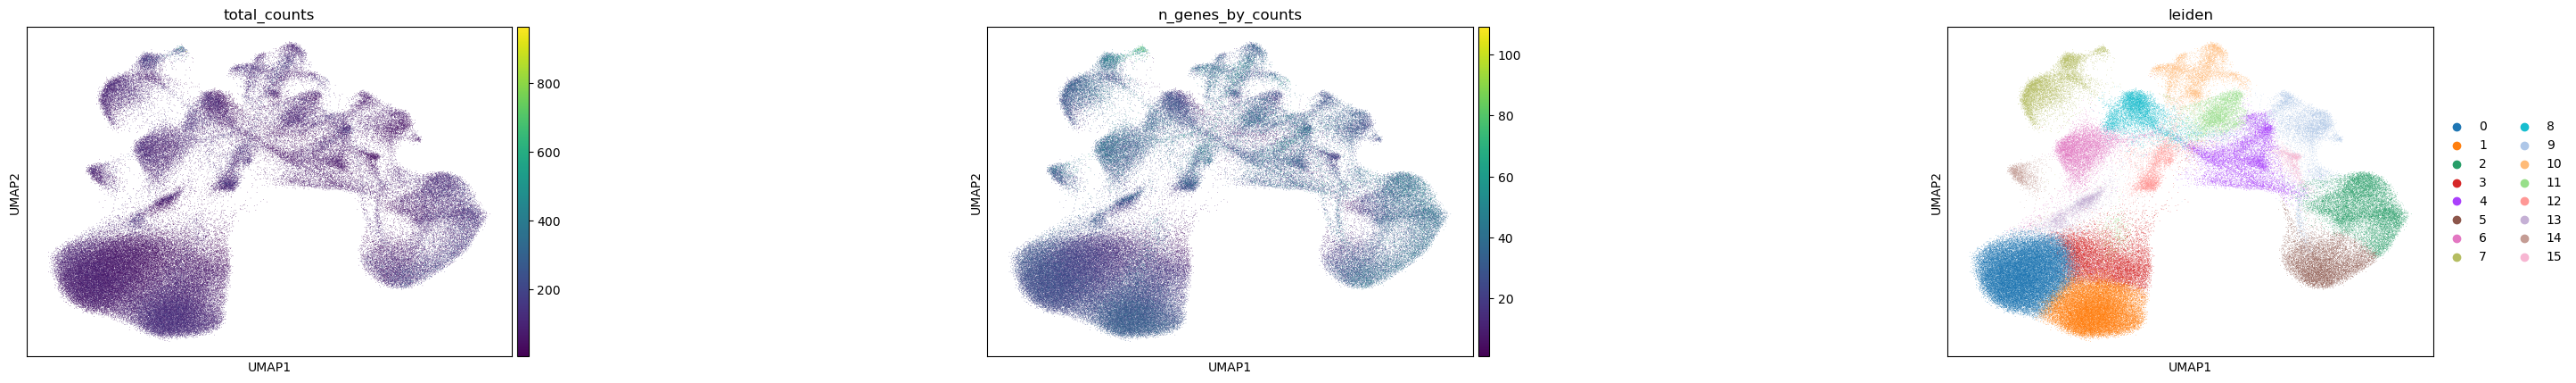

In [15]:
# umap
sc.pl.umap(
    adata,
    color=[
        "total_counts",
        "n_genes_by_counts",
        "leiden",
    ],
    wspace=0.8,
)

/opt/homebrew/Caskroom/miniconda/base/envs/TACCO_env/lib/python3.12/site-packages/squidpy/pl/_spatial_utils.py:981: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


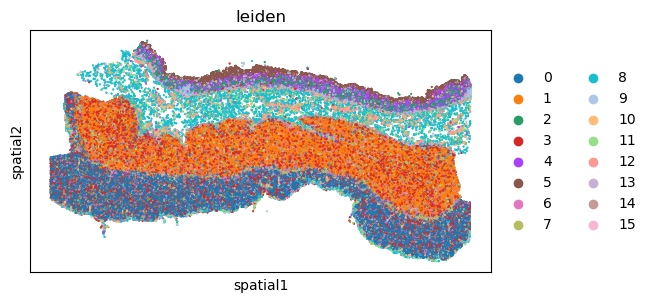

In [16]:
# spatial
sq.pl.spatial_scatter(
    adata,
    library_id="spatial",
    shape=None,
    color=[
        "leiden",
    ],
    wspace=0.4,
)

## False Discovery Rate

In [17]:
# total transcript calls (TTC)
total_transcript_calls = adata.obs['total_counts'].sum()
print(f"Total Transcript Calls: {total_transcript_calls}")

# negative control calls (NCC)
negative_control_calls = adata.obs['control_probe_counts'].sum()
print(f"Total Negative Control Calls: {negative_control_calls}")

# number of negative control probes (NCPs)
number_of_negative_control_probes = 20 ## VERIFY!

# number of real gene probes (RGPs)
number_of_panel_genes = 300 ## VERIFY!

# calculate FDR (10x)
fdr_step1 = (negative_control_calls / total_transcript_calls) * (number_of_panel_genes / number_of_negative_control_probes)
FDR_1 = fdr_step1 * 100
print(f"False Discovery Rate Xenium (FDR%): {FDR_1}%")

# calculate FDR (squidpy)
FDR_2 = (negative_control_calls / total_transcript_calls) * 100
print(f"False Discovery Rate Squidpy (FDR%): {FDR_2}%")

Total Transcript Calls: 11912968.0
Total Negative Control Calls: 568
False Discovery Rate Xenium (FDR%): 0.07151870130096884%
False Discovery Rate Squidpy (FDR%): 0.0047679134200645885%


## Post-Filtering Negative Probe Count and Negative Decoding Count

In [18]:
# calculate percentage of control probes and control codewords from adata.obs
cprobes = (
    adata.obs["control_probe_counts"].sum() / adata.obs["total_counts"].sum() * 100
)

cwords = (
    adata.obs["control_codeword_counts"].sum() / adata.obs["total_counts"].sum() * 100
)

print(f"Negative DNA Probe Count %: {cprobes}")
print(f"Negative Decoding Count %: {cwords}")

Negative DNA Probe Count %: 0.0047679134200645885
Negative Decoding Count %: 0.005833978568564945


## Post-QC Metrics

In [19]:
# total cells per mm2
total_cell_area_mm = total_cell_area_um2 / 1000000
cells_per_square_millimeter = len(adata.obs) / (total_cell_area_mm)
print(f"Total number of cells per square millimeter: {cells_per_square_millimeter:.2f}")

# total transcripts per cell
number_of_cells = adata.shape[0]
total_high_quality_transcripts = adata.obs['transcript_counts'].sum() / number_of_cells
print(f"Total Transcripts per cell post-QC: {total_high_quality_transcripts}")

# total cells
print(f"Total number of cells post-QC: {adata.shape[0]}")

# total high-quality decoded transcripts
total_high_quality_transcripts = adata.obs['transcript_counts'].sum()
print(f"Total number of transcripts post-QC: {total_high_quality_transcripts}")

# average area per cell
average_cell_area = adata.obs['cell_area'].mean()
print(f"Average cell area post-QC: {average_cell_area:.2f}")

# percent of cells without transcripts
cells_without_transcripts = (adata.obs['n_genes_by_counts'] == 0).sum()
total_cells = adata.shape[0]
percentage_without_transcripts = (cells_without_transcripts / total_cells) * 100
print(f"Percentage of cells without transcripts post-QC: {percentage_without_transcripts:.2f}%")

# median number of genes per cell
median_genes_per_cell = adata.obs['n_genes_by_counts'].median()
print(f"Median number of genes per cell post-QC: {median_genes_per_cell:.2f}")

# total genes per cell
total_gene_expressions = adata.obs['n_genes_by_counts'].sum()
average_genes_per_cell = total_gene_expressions / number_of_cells
print(f"Average number of genes per cell post-QC: {average_genes_per_cell:.2f}")

# median transcripts per cell
non_zero_transcripts = adata.obs[adata.obs['transcript_counts'] > 0]
median_transcripts = non_zero_transcripts['transcript_counts'].median()
print(f"Median transcripts per cell post-QC: {median_transcripts}")

Total number of cells per square millimeter: 17093.15
Total Transcripts per cell post-QC: 75.40712233039207
Total number of cells post-QC: 157982
Total number of transcripts post-QC: 11912968
Average cell area post-QC: 58.24
Percentage of cells without transcripts post-QC: 0.00%
Median number of genes per cell post-QC: 25.00
Average number of genes per cell post-QC: 25.93
Median transcripts per cell post-QC: 65.0


## Spatially Variable Genes

In [20]:
# calculate moran's I score
# I is the score, pval_norm is pvalue, var is variance, and corr_method is corrected p values
sq.gr.spatial_neighbors(adata, coord_type="generic", delaunay=True)
sq.gr.spatial_autocorr(
    adata,
    mode="moran",
    n_perms=100,
    n_jobs=1,
)

  0%|          | 0/100 [00:00<?, ?/s]

In [21]:
# inspect result
adata.uns["moranI"].head(10)

I  pval_norm  var_norm  pval_z_sim  pval_sim   var_sim  \
PIGR     0.881921        0.0  0.000002         0.0  0.009901  0.000005   
EPCAM    0.810942        0.0  0.000002         0.0  0.009901  0.000005   
MYH11    0.801695        0.0  0.000002         0.0  0.009901  0.000004   
CEACAM1  0.798875        0.0  0.000002         0.0  0.009901  0.000004   
FCGBP    0.763058        0.0  0.000002         0.0  0.009901  0.000004   
CLCA4    0.724622        0.0  0.000002         0.0  0.009901  0.000005   
TAGLN    0.696211        0.0  0.000002         0.0  0.009901  0.000004   
OLFM4    0.656337        0.0  0.000002         0.0  0.009901  0.000004   
ACTA2    0.605060        0.0  0.000002         0.0  0.009901  0.000004   
CA4      0.601000        0.0  0.000002         0.0  0.009901  0.000005   

         pval_norm_fdr_bh  pval_z_sim_fdr_bh  pval_sim_fdr_bh  
PIGR                  0.0                0.0         0.010821  
EPCAM                 0.0                0.0         0.010821  
MYH11                 0.0                0.0         0.010821  
CEACAM1               0.0                0.0         0.010821  
FCGBP                 0.0                0.0         0.010821  
CLCA4                 0.0                0.0         0.010821  
TAGLN                 0.0                0.0         0.010821  
OLFM4                 0.0                0.0         0.010821  
ACTA2                 0.0                0.0         0.010821  
CA4                   0.0                0.0         0.010821

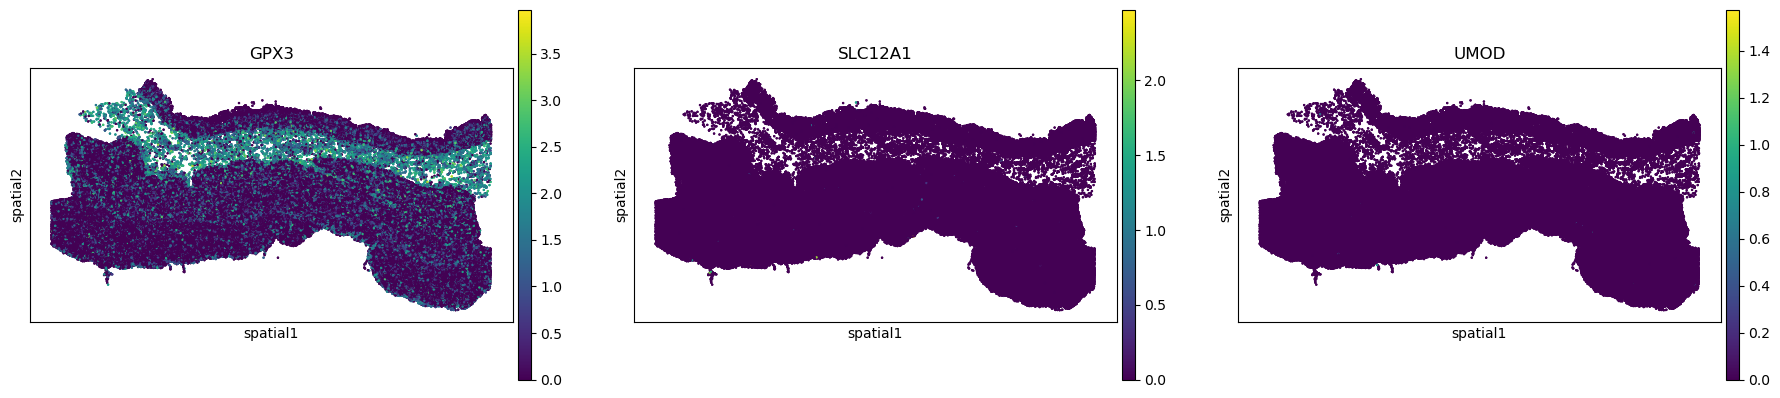

In [22]:
# plot selected highly variable genes
sq.pl.spatial_scatter(
    adata,
    library_id="spatial",
    color=[
        "GPX3",
        "SLC12A1",
        "UMOD",
    ],
    shape=None,
    size=2,
    img=False,
)

## Gene Visualization

In [23]:
# visualize select genes
sq.pl.spatial_scatter(
   adata,
   library_id="spatial",
   color=[
       "AQP2",
       "CALB1",
       "GPX3",
    ],
    shape=None,
    size=2,
    img=False,
    figsize=(3, 8)
)

Error in callback <function flush_figures at 0x1c9f6b740> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

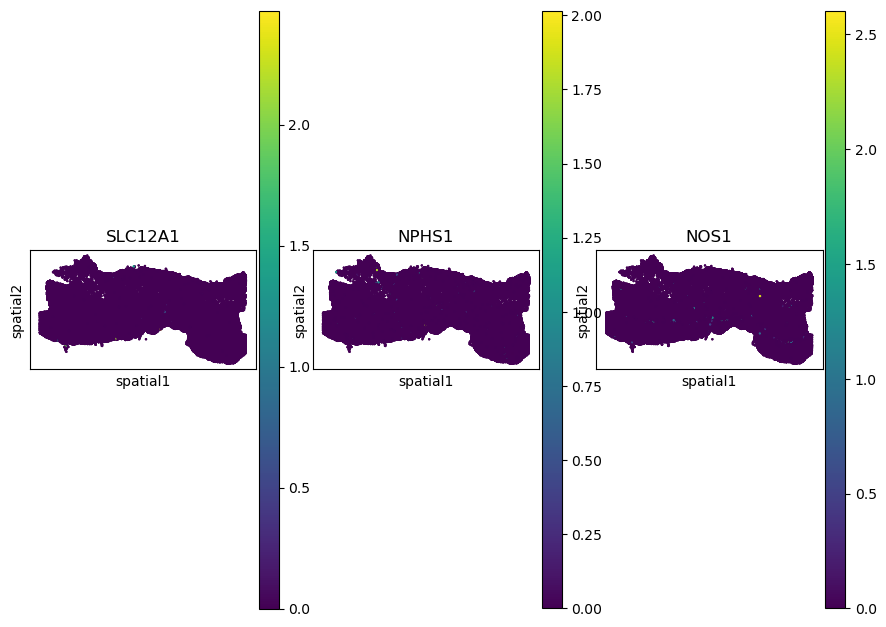

In [24]:
sq.pl.spatial_scatter(
   adata,
   library_id="spatial",
   color=[
       "SLC12A1",
       "NPHS1",
       "NOS1",
    ],
    shape=None,
    size=2,
    img=False,
    figsize=(3, 8)
)

## Import Desired Reference Object

In [25]:
# adata_5000_nodegen = ad.read_h5ad("/Users/stephreinert/Desktop/atlas_v2/downsampled_atlasv2_nodegen_5kcells.h5ad")
# adata_5000 = ad.read_h5ad("/Users/stephreinert/Desktop/atlas_v2/downsampled_atlasv2_5kcells.h5ad")
adata_50prop = ad.read_h5ad("/Users/stephreinert/Desktop/atlas_v2/atlasv2_ds_50prop.h5ad")

## TACCO

In [26]:
tc.tl.annotate(adata, adata_50prop, annotation_key='v2.subclass.l1', result_key='v2.subclass.l1', assume_valid_counts=True,max_annotation = 1)

Starting preprocessing
Annotation profiles were not found in `reference.varm["v2.subclass.l1"]`. Constructing reference profiles with `tacco.preprocessing.construct_reference_profiles` and default arguments...
Finished preprocessing in 66.47 seconds.
Starting annotation of data with shape (157982, 300) and a reference of shape (694299, 300) using the following wrapped method:
+- maximum annotation: max_annotation=1
   +- platform normalization: platform_iterations=0, gene_keys=v2.subclass.l1, normalize_to=adata
      +- multi center: multi_center=None multi_center_amplitudes=True
         +- bisection boost: bisections=4, bisection_divisor=3
            +- core: method=OT annotation_prior=None
mean,std( rescaling(gene) )  0.729250426013437 3.1914658316591176
bisection run on 1
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Ex

AnnData object with n_obs × n_vars = 157982 × 300
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes', 'n_counts', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'pca', 'neighbors', 'hvg', 'umap', 'leiden', 'leiden_colors', 'spatial_neighbors', 'moranI'
    obsm: 'spatial', 'X_pca', 'X_umap', 'v2.subclass.l1'
    varm: 'PCs', 'v2.subclass.l1'
    layers: 'counts'
    obsp: 'distances', 'connectivities', 'spatial_

In [27]:
y = adata.obsm['v2.subclass.l1']
# Find the column where the value is 1.0
y['v2.subclass.l1'] = y.idxmax(axis=1)

In [28]:
adata.obs['v2.subclass.l1'] = y['v2.subclass.l1']

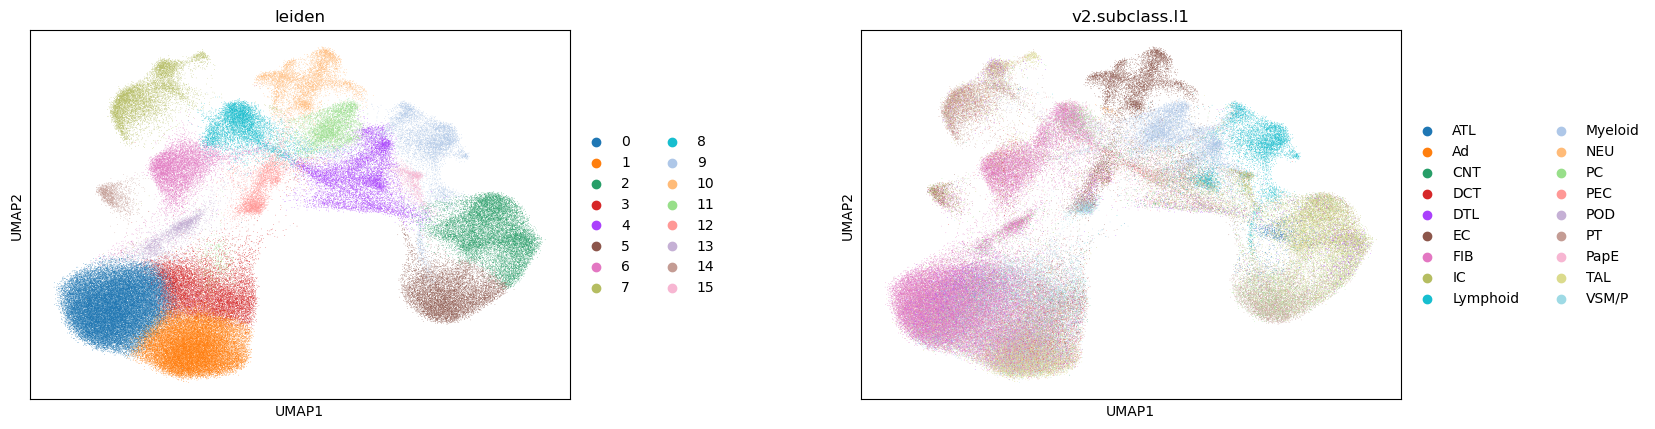

In [29]:
sc.pl.umap(
    adata,
    color=[
        "leiden",'v2.subclass.l1'
    ],
    wspace=0.4,
)

In [30]:
adata.obs['v2.subclass.l1'].value_counts()

v2.subclass.l1
FIB         50595
PT          22514
TAL         21820
VSM/P       14169
EC           8782
Myeloid      8564
PC           7199
Lymphoid     6115
IC           5092
DTL          5010
DCT          2275
POD          1632
PEC          1475
ATL          1013
CNT           997
PapE          614
NEU            62
Ad             54
Name: count, dtype: int64

In [31]:
tc.tl.annotate(adata, adata_50prop, annotation_key='v2.subclass.l2', result_key='v2.subclass.l2', assume_valid_counts=True,max_annotation = 1)

Starting preprocessing
Annotation profiles were not found in `reference.varm["v2.subclass.l2"]`. Constructing reference profiles with `tacco.preprocessing.construct_reference_profiles` and default arguments...
Finished preprocessing in 80.1 seconds.
Starting annotation of data with shape (157982, 300) and a reference of shape (694299, 300) using the following wrapped method:
+- maximum annotation: max_annotation=1
   +- platform normalization: platform_iterations=0, gene_keys=v2.subclass.l2, normalize_to=adata
      +- multi center: multi_center=None multi_center_amplitudes=True
         +- bisection boost: bisections=4, bisection_divisor=3
            +- core: method=OT annotation_prior=None
mean,std( rescaling(gene) )  0.729250426013437 3.1914658316591176
bisection run on 1
bisection run on 0.6666666666666667
bisection run on 0.4444444444444444
bisection run on 0.2962962962962963
bisection run on 0.19753086419753085
bisection run on 0.09876543209876543
Finished annotation in 22.4 sec

AnnData object with n_obs × n_vars = 157982 × 300
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes', 'n_counts', 'leiden', 'v2.subclass.l1'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'pca', 'neighbors', 'hvg', 'umap', 'leiden', 'leiden_colors', 'spatial_neighbors', 'moranI', 'v2.subclass.l1_colors'
    obsm: 'spatial', 'X_pca', 'X_umap', 'v2.subclass.l1', 'v2.subclass.l2'
    varm: 'PCs', 'v2.subclass.l1', 'v2.subcl

In [32]:
y = adata.obsm['v2.subclass.l2']
# find the column where the value is 1.0
y['v2.subclass.l2'] = y.idxmax(axis=1)

In [33]:
adata.obs['v2.subclass.l2'] = y['v2.subclass.l2']
adata.obs

cell_id    x_centroid   y_centroid  transcript_counts  \
aaaaball-1  aaaaball-1     99.288048  4084.526855                110   
aaaablia-1  aaaablia-1     35.367649  4224.959473                 17   
aaaadnjm-1  aaaadnjm-1    165.286621  4206.954590                109   
aaabfjbj-1  aaabfjbj-1    241.623291  3851.037109                 45   
aaablnhn-1  aaablnhn-1    391.384583  4047.874756                 58   
...                ...           ...          ...                ...   
oilenopj-1  oilenopj-1   9502.899414  1968.887451                  9   
oilfejgg-1  oilfejgg-1  10540.246094  1848.314087                 81   
oilfnhid-1  oilfnhid-1   8646.413086  2006.301147                 11   
oilggicj-1  oilggicj-1   8576.546875  2052.158691                 17   
oilgnipn-1  oilgnipn-1   8677.762695  1935.945801                 12   

            control_probe_counts  control_codeword_counts  \
aaaaball-1                     0                        0   
aaaablia-1                     0                        0   
aaaadnjm-1                     0                        0   
aaabfjbj-1                     0                        0   
aaablnhn-1                     0                        0   
...                          ...                      ...   
oilenopj-1                     0                        0   
oilfejgg-1                     0                        0   
oilfnhid-1                     0                        0   
oilggicj-1                     0                        0   
oilgnipn-1                     0                        0   

            unassigned_codeword_counts  deprecated_codeword_counts  \
aaaaball-1                           0                           0   
aaaablia-1                           0                           0   
aaaadnjm-1                           0                           0   
aaabfjbj-1                           0                           0   
aaablnhn-1                           0                           0   
...                                ...                         ...   
oilenopj-1                           0                           0   
oilfejgg-1                           0                           0   
oilfnhid-1                           0                           0   
oilggicj-1                           0                           0   
oilgnipn-1                           0                           0   

            total_counts   cell_area  ...  log1p_n_genes_by_counts  \
aaaaball-1         110.0   73.378909  ...                 3.761200   
aaaablia-1          17.0   43.033908  ...                 2.079442   
aaaadnjm-1         109.0   60.373908  ...                 3.761200   
aaabfjbj-1          45.0   33.776876  ...                 3.295837   
aaablnhn-1          58.0   34.409064  ...                 3.433987   
...                  ...         ...  ...                      ...   
oilenopj-1           9.0  121.876723  ...                 2.079442   
oilfejgg-1          81.0  126.934223  ...                 3.555348   
oilfnhid-1          11.0   18.423751  ...                 2.397895   
oilggicj-1          17.0   28.087189  ...                 2.564949   
oilgnipn-1          12.0    5.960625  ...                 2.302585   

            log1p_total_counts  pct_counts_in_top_10_genes  \
aaaaball-1            4.709530                   57.272727   
aaaablia-1            2.890372                  100.000000   
aaaadnjm-1            4.700480                   57.798165   
aaabfjbj-1            3.828641                   64.444444   
aaablnhn-1            4.077538                   62.068966   
...                        ...                         ...   
oilenopj-1            2.302585                  100.000000   
oilfejgg-1            4.406719                   61.728395   
oilfnhid-1            2.484907                  100.000000   
oilggicj-1            2.890372                   88.235294   
oilgnipn-1            2.564949                  100.0

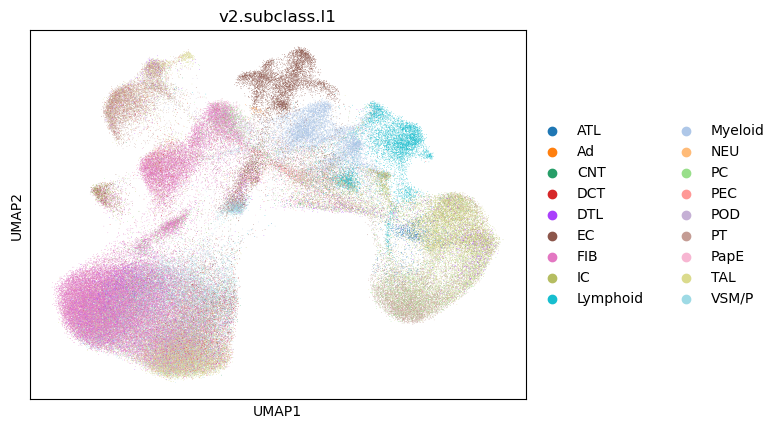

In [34]:
sc.pl.umap(adata, color=['v2.subclass.l1'], save="3781_Xen3_umap_l1.png")

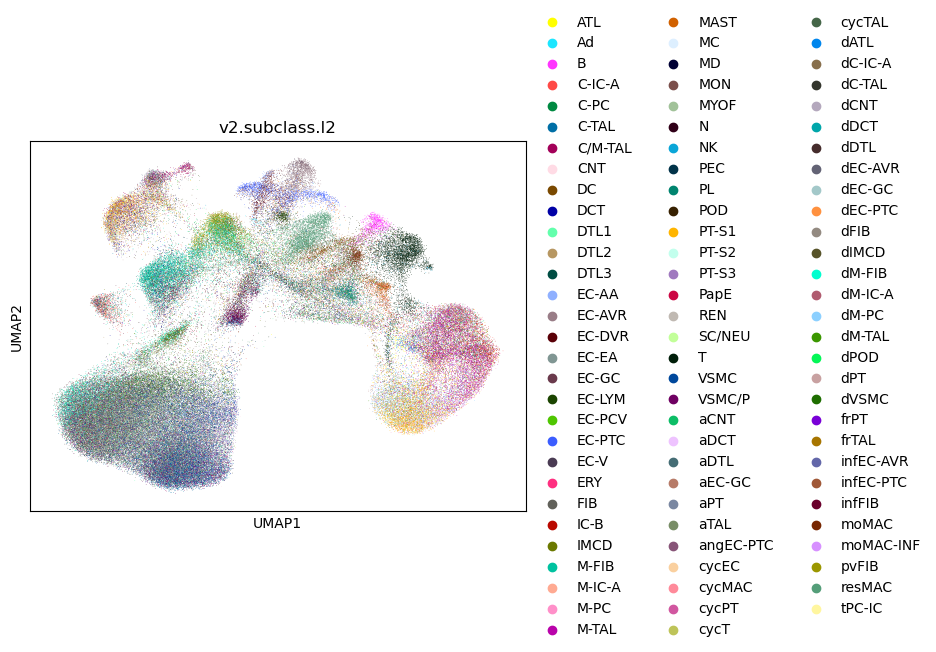

In [35]:
sc.pl.umap(adata, color=['v2.subclass.l2'], save="3781_Xen3_umap_l2.png")

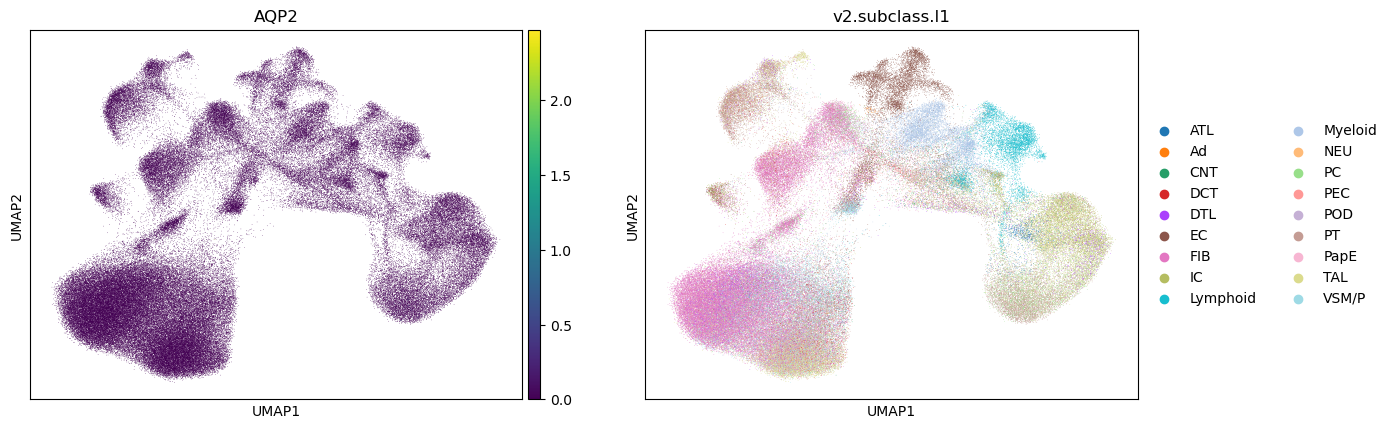

In [36]:
sc.pl.umap(adata, color=['AQP2','v2.subclass.l1'])

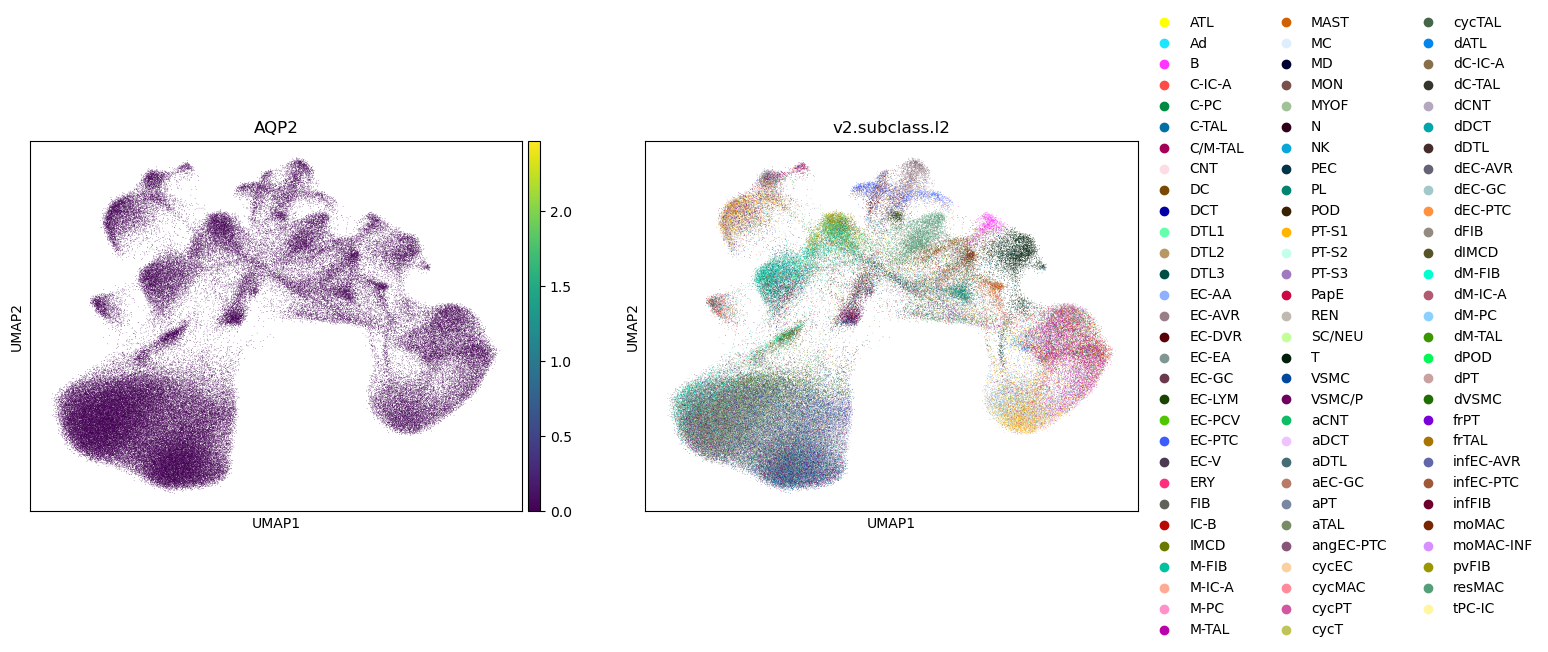

In [37]:
sc.pl.umap(adata, color=['AQP2','v2.subclass.l2'])

/opt/homebrew/Caskroom/miniconda/base/envs/TACCO_env/lib/python3.12/site-packages/squidpy/pl/_spatial_utils.py:981: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


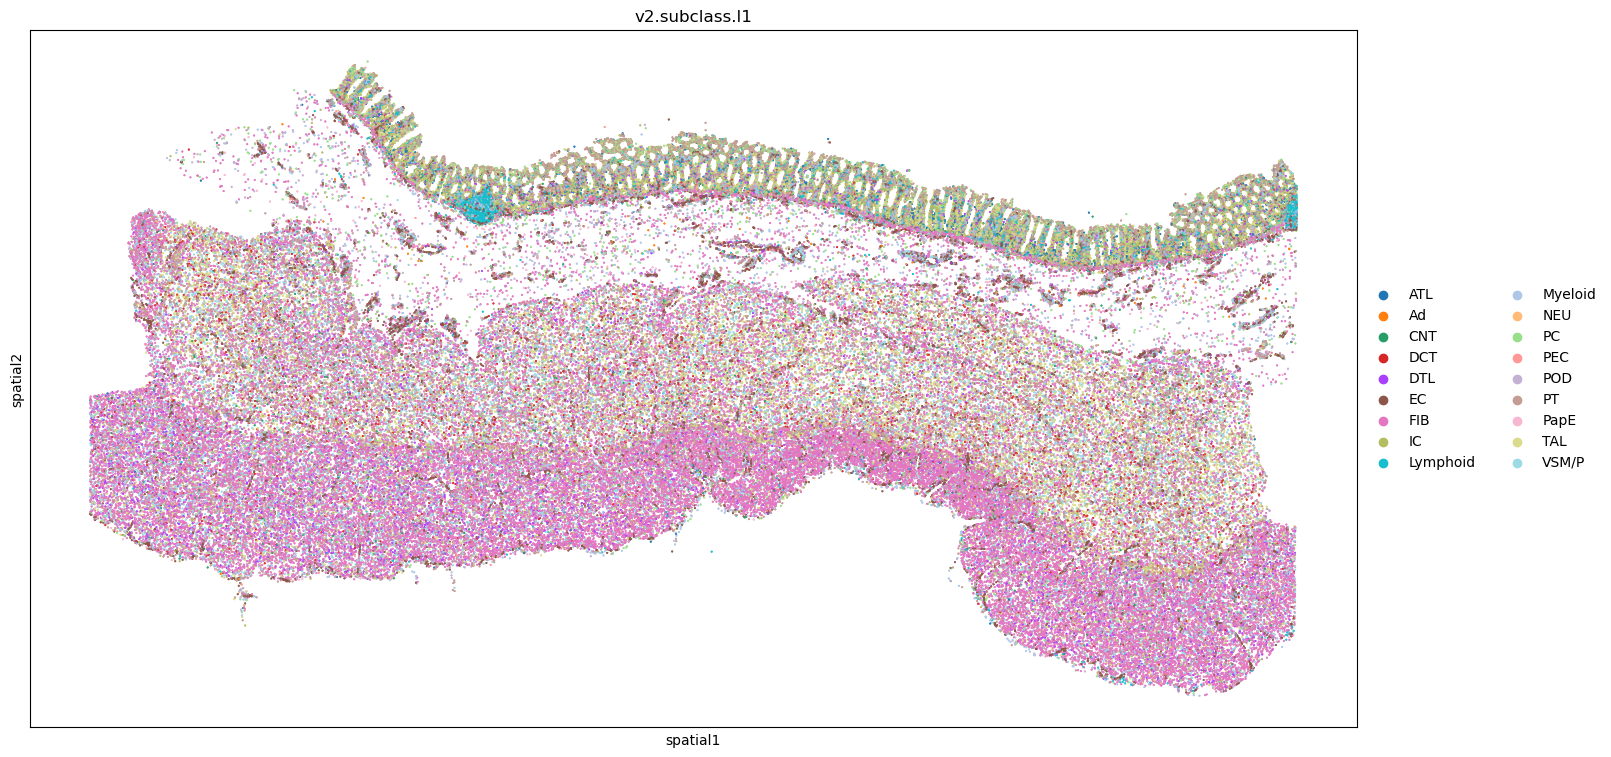

In [38]:
sq.pl.spatial_scatter(
    adata,
    library_id="spatial",
    shape=None,
    figsize = (16,14),
    color=[
        "v2.subclass.l1",
    ],
)

plt.savefig('/Users/stephreinert/Desktop/xenium/figures/3781_Xen3_spatial_scatter_plot.png', dpi=300, bbox_inches='tight')

In [39]:
pd.crosstab(index=adata.obs['v2.subclass.l2'], columns=adata.obs['v2.subclass.l1'])

v2.subclass.l1  ATL  Ad  CNT  DCT  DTL  EC   FIB    IC  Lymphoid  Myeloid  \
v2.subclass.l2                                                              
ATL             354   0    3    1   18   5    21    25         1        0   
Ad                0  44    0    0    0   1    11     0         0        0   
B                 2   0    0    0    2  16     0     7       691      155   
C-IC-A            0   0    2    8    9  15   169  1285         3        9   
C-PC              0   0   12    4   25   0   136    13         0        0   
...             ...  ..  ...  ...  ...  ..   ...   ...       ...      ...   
moMAC             0   0    0    1    0   0     0     3         2      811   
moMAC-INF         0   0    0    0    0   1     0     0         2      117   
pvFIB             2   3    3   25    0  11  1594     8         2        6   
resMAC            1   0    1    0    4  56    49     6         4     4845   
tPC-IC            0   0    0    0    0   0     0     2         0        0   

v2.subclass.l1  NEU   PC  PEC  POD   PT  PapE  TAL  VSM/P  
v2.subclass.l2                                             
ATL               0   52    0    1   56     0   37      5  
Ad                0    2    0    1    7     0    2      3  
B                 0   38    0    3   16     1    1      0  
C-IC-A            0   23    5    5  174     0   68     12  
C-PC              0  462    0    1  131     0  236     84  
...             ...  ...  ...  ...  ...   ...  ...    ...  
moMAC             0    3    0    0   10     0    4      0  
moMAC-INF         0    0    1    0    2     0    1      0  
pvFIB             0  145    1  167  107   243   10      6  
resMAC            0   18    1   10  122     2   40      5  
tPC-IC            0    4    0    0    2     0    3      0  

[89 rows x 18 columns]

In [40]:
adata.obs['v2.subclass.l1'].value_counts()

v2.subclass.l1
FIB         50595
PT          22514
TAL         21820
VSM/P       14169
EC           8782
Myeloid      8564
PC           7199
Lymphoid     6115
IC           5092
DTL          5010
DCT          2275
POD          1632
PEC          1475
ATL          1013
CNT           997
PapE          614
NEU            62
Ad             54
Name: count, dtype: int64

In [41]:
# calculate the value counts
value_counts = adata.obs['v2.subclass.l2'].value_counts()

# convert the value counts to a DataFrame
value_counts_df = value_counts.reset_index()

# rename columns for better readability
value_counts_df.columns = ['v2.subclass.l2', 'count']

# set pandas option to display all rows
pd.set_option('display.max_rows', None)

# display
print(value_counts_df)

   v2.subclass.l2  count
0             FIB  17686
1            MYOF  12851
2           M-FIB   7643
3          VSMC/P   7355
4            VSMC   7143
5           PT-S1   6604
6           C-TAL   6056
7          resMAC   5164
8           M-TAL   5115
9               T   4407
10            dPT   3832
11            aPT   3718
12        C/M-TAL   3555
13          PT-S3   3068
14            DCT   2931
15         dM-FIB   2583
16          dM-PC   2463
17          pvFIB   2333
18          dVSMC   2179
19           DTL1   2120
20         EC-DVR   1975
21         EC-AVR   1939
22         dM-TAL   1907
23            PEC   1862
24         EC-PTC   1828
25         C-IC-A   1787
26            CNT   1697
27           DTL2   1688
28           aTAL   1664
29           M-PC   1579
30           dFIB   1522
31           IMCD   1417
32             DC   1367
33          PT-S2   1273
34         infFIB   1214
35             PL   1207
36           C-PC   1104
37            POD   1043
38          frTAL   1019


In [42]:
# transcript count per cell type in v2.subclass.l1
transcript_counts_per_type = adata.obs.groupby('v2.subclass.l1', observed=True)['transcript_counts'].sum()
transcript_counts_per_type_df = transcript_counts_per_type.reset_index()
transcript_counts_per_type_df = transcript_counts_per_type_df.sort_values(by='transcript_counts', ascending=False)
print(transcript_counts_per_type_df)

# save to an Excel file
#transcript_counts_per_type_df.to_excel("transcript_counts_per_cell_type_l1.xlsx", index=False# number of cells per cell type in 'v2.subclass.l1'
cell_counts_per_type = adata.obs['v2.subclass.l1'].value_counts(sort=False)
cell_counts_per_type_df = cell_counts_per_type.reset_index()
cell_counts_per_type_df.columns = ['v2.subclass.l1', 'cell_count']

# proportion of cells per cell type in 'v2.subclass.l1'
cell_proportion_per_type = adata.obs['v2.subclass.l1'].value_counts(normalize=True, sort=False) * 100
cell_proportion_per_type_df = cell_proportion_per_type.reset_index()
cell_proportion_per_type_df.columns = ['v2.subclass.l1', 'proportion (%)']

# merge 
cell_counts_and_proportions_df = pd.merge(cell_counts_per_type_df, cell_proportion_per_type_df, on='v2.subclass.l1')

# sort and print
cell_counts_and_proportions_df = cell_counts_and_proportions_df.sort_values(by='cell_count', ascending=False)
print(cell_counts_and_proportions_df)

# save to excel
output_file_path = "/Users/stephreinert/Desktop/xenium/stats/3781_Xen3_subclass_counts_l1.xlsx"
cell_counts_and_proportions_df.to_excel(output_file_path, index=False)

print(f"DataFrame saved to {output_file_path}")

   v2.subclass.l1  transcript_counts
6             FIB            3493521
16            TAL            2159094
14             PT            1894266
17          VSM/P             849166
5              EC             768373
9         Myeloid             674997
11             PC             540495
7              IC             417225
8        Lymphoid             349265
4             DTL             325039
3             DCT             166110
12            PEC              86363
13            POD              71689
2             CNT              41409
0             ATL              40432
15           PapE              28143
1              Ad               4799
10            NEU               2582
   v2.subclass.l1  cell_count  proportion (%)
6             FIB       50595       32.025800
14             PT       22514       14.250991
16            TAL       21820       13.811700
17          VSM/P       14169        8.968743
5              EC        8782        5.558861
9         Myeloid    

In [43]:
# number of cells per cell type in 'v2.subclass.l2'
cell_counts_per_type = adata.obs['v2.subclass.l2'].value_counts(sort=False)
cell_counts_per_type_df = cell_counts_per_type.reset_index()
cell_counts_per_type_df.columns = ['v2.subclass.l2', 'cell_count']

# proportion of cells per cell type in 'v2.subclass.l2'
cell_proportion_per_type = adata.obs['v2.subclass.l2'].value_counts(normalize=True, sort=False) * 100
cell_proportion_per_type_df = cell_proportion_per_type.reset_index()
cell_proportion_per_type_df.columns = ['v2.subclass.l2', 'proportion (%)']

# merge 
cell_counts_and_proportions_df = pd.merge(cell_counts_per_type_df, cell_proportion_per_type_df, on='v2.subclass.l2')

# sort and print
cell_counts_and_proportions_df = cell_counts_and_proportions_df.sort_values(by='cell_count', ascending=False)
print(cell_counts_and_proportions_df)

# save to excel
output_file_path = "/Users/stephreinert/Desktop/xenium/stats/3781_Xen3_subclass_counts_l2.xlsx"
cell_counts_and_proportions_df.to_excel(output_file_path, index=False)

print(f"DataFrame saved to {output_file_path}")

   v2.subclass.l2  cell_count  proportion (%)
23            FIB       17686       11.194946
34           MYOF       12851        8.134471
26          M-FIB        7643        4.837893
48         VSMC/P        7355        4.655594
47           VSMC        7143        4.521401
40          PT-S1        6604        4.180223
5           C-TAL        6056        3.833348
87         resMAC        5164        3.268727
29          M-TAL        5115        3.237711
46              T        4407        2.789558
77            dPT        3832        2.425593
53            aPT        3718        2.353433
6         C/M-TAL        3555        2.250256
42          PT-S3        3068        1.941993
9             DCT        2931        1.855275
72         dM-FIB        2583        1.634996
74          dM-PC        2463        1.559038
86          pvFIB        2333        1.476751
78          dVSMC        2179        1.379271
10           DTL1        2120        1.341925
15         EC-DVR        1975     

## Add Metadata

In [44]:
adata.obs['sample_id'] = 'K2200084_7'
adata.obs['library_id'] = 'Xen_3'
adata.obs['Panel'] = '300KID'
adata.obs['PPID'] = '3781'
adata.obs['Condition'] = 'Ref'
adata.obs['sample_source'] = 'Nephrectomy'
adata.obs['time_interval'] = '16'
adata.obs['region'] = 'Cortex_Medulla'
adata.obs['full_id'] = '3781_Xen3'

In [45]:
adata

AnnData object with n_obs × n_vars = 157982 × 300
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes', 'n_counts', 'leiden', 'v2.subclass.l1', 'v2.subclass.l2', 'sample_id', 'library_id', 'Panel', 'PPID', 'Condition', 'sample_source', 'time_interval', 'region', 'full_id'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'pca', 'neighbors', 'hvg', 'umap', 'leiden', 'leiden_colors', 'spatial_neighbors', 'moranI', 'v2.subclass.

## Save Object

In [46]:
# remove a specific key from the obsm attribute, e.g., 'v2.subclass.l1'
del adata.obsm['v2.subclass.l1']

# remove another specific key from the obsm attribute, e.g., 'v2.subclass.l2'
del adata.obsm['v2.subclass.l2']

# remove a specific key from the varm attribute, e.g., 'v2.subclass.l1'
del adata.varm['v2.subclass.l1']

# remove another specific key from the varm attribute, e.g., 'v2.subclass.l2'
del adata.varm['v2.subclass.l2']

In [47]:
adata.write_h5ad("/Users/stephreinert/Desktop/xenium/objects/3781_Xen3_obj.h5ad")